# **Convolutional Neural Network (CNN)**

---

## **Introduction**

Convolutional Neural Network (CNN) is a class of deep learning models designed for processing grid-like data structures, such as images, time-series signals, thus CNN. Therefore, CNN has a wide range of applications in BCI.

Core ideas of CNN:
- Local Receptive Field
- Weight Sharing
- Hierarchical Feature Extraction

---

## **Basic Structure**

CNN consists of several key modules:

### (1) Convolution Layer

The convolution operation is defined as:

$$
y_{i,j}^{(k)} = \sum_{m} \sum_{n} x_{i+m, j+n} \cdot w_{m, n}^{(k)} + b^{(k)}
$$

Where:
- $x$ is the input feature map;
- $w$ is the kernel parameter;
- $b$ is the bias;
- $y$ is the output feature map.

Convolution is used to automatically extract local features (edges, textures, etc.).

---

### (2) Activation Function

A commonly used activation function is ReLU:

$$
f(x) = \max(0, x)
$$

This introduces non-linearity and improves model expressiveness.

---

### (3) Pooling Layer

Pooling operation reduces the size of feature maps and computation cost.

For example, Max Pooling:

$$
y_{i,j} = \max_{(m,n) \in \text{window}} x_{i+m, j+n}
$$

---

### (4) Fully Connected Layer

After the convolution and pooling operations, the feature map is flattened and passed through fully connected layers:

$$
y = W x + b
$$

---

### (5) Softmax Layer

For multi-class classification tasks, the final layer usually applies Softmax:

$$
P(y=k|x) = \frac{\exp(z_k)}{\sum_{j=1}^{K} \exp(z_j)}
$$

---

## **Typical CNN Architecture**

A typical CNN architecture:

Input Data (e.g., Image, EEG signal)    
→ Convolution + Activation  
→ Pooling   
→ Multiple Convolution + Pooling Layers     
→ Flatten   
→ Fully Connected Layer     
→ Softmax Classification    

---

## **Advantages of CNN**

| Advantages | Description |
|------------|-------------|
| Fewer Parameters | Weight sharing significantly reduces parameters compared to fully connected networks |
| Automatic Feature Extraction | No manual feature engineering needed |
| Spatial Structure Preservation | Local connection and spatial invariance |
| Transferability | Features are generic and transferable across tasks |

---

## **Classic CNN Models**

| Model Name | Characteristics | Application Scenario |
|------------|-----------------|----------------------|
| LeNet | The earliest CNN model | Handwritten digit recognition |
| AlexNet | Huge performance improvement | Image classification |
| VGG | Stacking small kernels | Image recognition |
| ResNet | Residual structure solves gradient vanishing | Deep networks |
| EEGNet | Designed for EEG signals | EEG signal classification |

---

## **Application Scenarios**

CNN is widely used in:

- Image Classification  
- Object Detection  
- Natural Language Processing (NLP)  
- EEG Signal Decoding  
- Medical Image Analysis  
- Video Recognition  

---

## **CNN in BCI**

### Typical Applications:
- Motor Imagery Classification  
- P300 Signal Detection  
- Steady-State Visual Evoked Potential (SSVEP) Recognition  
- Emotion Recognition based on EEG  

### Advantages in BCI:
- Automatic feature extraction from raw or preprocessed EEG data  
- Robust to noise and artifacts in EEG signals  
- Adaptable to different electrode layouts and signal types  
- Effective in both subject-specific and cross-subject learning  

---

## **Prerequisites**

- `numpy`  
- `scikit-learn`  
- `matplotlib`  
- `torch`  

---

In practical use, the model generally needs to stack more layers and adjust appropriate parameters at the same time.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

from utils import (
    load_data_model,
)

# load train and test data
data_dir = "../data/data_model/sub-jimingda/forward1.npz"
data_list = load_data_model(data_dir)
train_data, train_label, test_data, test_label = data_list["feature_train"], data_list["steering_train"], data_list["feature_test"], data_list["steering_test"]

In [ ]:
# DataLoader
train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float32), 
                              torch.tensor(train_label, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(test_data, dtype=torch.float32), 
                             torch.tensor(test_label, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
class EEG_CNN(nn.Module):
    def __init__(self):
        super(EEG_CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # input: (1,63,200)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # output: (16,31,100)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # output: (32,15,50)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # output: (64,7,25)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 25, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Regression output
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x.squeeze()

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20
train_loss_list = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.unsqueeze(1).to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_loss_list.append(epoch_loss)
    # print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/20], Loss: 0.0269
Epoch [2/20], Loss: 0.0063
Epoch [3/20], Loss: 0.0056
Epoch [4/20], Loss: 0.0047
Epoch [5/20], Loss: 0.0035
Epoch [6/20], Loss: 0.0024
Epoch [7/20], Loss: 0.0017
Epoch [8/20], Loss: 0.0013
Epoch [9/20], Loss: 0.0010
Epoch [10/20], Loss: 0.0008
Epoch [11/20], Loss: 0.0007
Epoch [12/20], Loss: 0.0006
Epoch [13/20], Loss: 0.0005
Epoch [14/20], Loss: 0.0005
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0004
Epoch [17/20], Loss: 0.0004
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0003


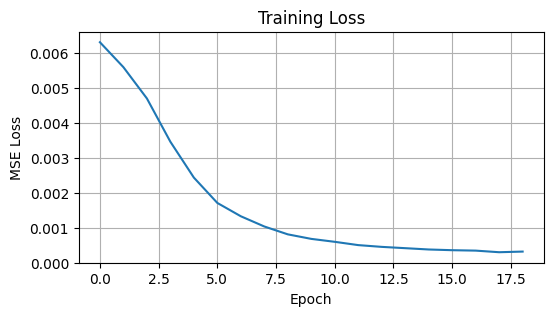

In [68]:
plt.figure(figsize=(6, 3))
plt.plot(train_loss_list[1:])
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

In [ ]:
model.eval()
preds = []
gts = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.unsqueeze(1).to(device)
        output = model(x_batch)
        preds.append(output.cpu().numpy())
        gts.append(y_batch.numpy())

preds = np.concatenate(preds)
gts = np.concatenate(gts)

mse = mean_squared_error(gts, preds)
print(f'Test MSE: {mse:.4f}')

Test MSE: 0.0049


In [69]:
# Save model parameters
# torch.save(model.state_dict(), 'cnn_eeg_regression.pth')
# print('Model saved.')
# model = EEG_CNN().to(device)
# model.load_state_dict(torch.load('cnn_eeg_regression.pth'))
# model.eval()
# print('Model loaded.')

In [70]:
# plt.figure(figsize=(6,3))
# plt.plot(gts, '-', alpha=0.5, color='blue')
# plt.plot(preds, '-', alpha=0.5, color='orange')
# plt.xlim(500, 1000)
# plt.ylim(-0.2, 0.2)
# plt.xlabel('Ground Truth')
# plt.ylabel('Prediction')
# plt.title('Prediction vs Ground Truth')
# plt.grid()
# plt.show()